<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Specific-analyses" data-toc-modified-id="Specific-analyses-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Specific analyses</a></span><ul class="toc-item"><li><span><a href="#Non-diseased-animals:-difference-WT-vs.-Pax5+/-" data-toc-modified-id="Non-diseased-animals:-difference-WT-vs.-Pax5+/--1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Non-diseased animals: difference WT vs. Pax5+/-</a></span></li><li><span><a href="#Pax5+/--animals:-sick-vs.-healthy" data-toc-modified-id="Pax5+/--animals:-sick-vs.-healthy-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pax5+/- animals: sick vs. healthy</a></span></li><li><span><a href="#In-Order-to-limit-diff-abundant-compounds:-compare-all-20-Pax5-vs.-10-WT-(ignoring-ABX-treatment)" data-toc-modified-id="In-Order-to-limit-diff-abundant-compounds:-compare-all-20-Pax5-vs.-10-WT-(ignoring-ABX-treatment)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>In Order to limit diff abundant compounds: compare all 20 Pax5 vs. 10 WT (ignoring ABX treatment)</a></span></li></ul></li><li><span><a href="#Volcano-Plot" data-toc-modified-id="Volcano-Plot-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Volcano Plot</a></span></li><li><span><a href="#Speculation-about-Chorismate-Pathway" data-toc-modified-id="Speculation-about-Chorismate-Pathway-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Speculation about Chorismate Pathway</a></span></li></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.environ["PROJ_LIB"] = "/homes/sjanssen/miniconda3/envs/notebookServer/share/proj"

import pandas as pd
import numpy as np
from skbio.tree import TreeNode
from itertools import combinations
from scipy.stats import mannwhitneyu
from skbio.stats.distance import mantel
from glob import glob
from os.path import join, basename
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from ggmap.snippets import *
from ggmap.analyses import *
from ggmap.correlations import *
from ggmap.workflow import *
import calour as ca
ca.set_log_level(40)
import io

import requests
import json
import fetch
from ggmap.tree import *
from ggmap.utils import *
from ggmap.readwrite import *

from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.stats import ttest_ind

ggmap is custome code from Stefan Janssen, download at https://github.com/sjanssen2/ggmap
Reading settings file '/homes/sjanssen/.ggmaprc'
ggmap is custome code from Stefan Janssen, download at https://github.com/sjanssen2/ggmap
Reading settings file '/homes/sjanssen/.ggmaprc'


In [2]:
def _savefig(fig, name):
    os.makedirs('Figures_generated/SVG', exist_ok=True)
    os.makedirs('Figures_generated/PNG', exist_ok=True)
    
    fig.savefig('Figures_generated/SVG/%s.svg' % name, bbox_inches='tight')
    fig.savefig('Figures_generated/PNG/%s.png' % name, bbox_inches='tight')
    
keggmap = {
    'DL-Glutamine__146.06889__2.661': 'C00064',
    '2-Oxoglutaric acid__146.02129__15.709': 'C00026',
    'Phosphoenolpyruvic acid__167.98221__15.803': 'C00074',
    'D-Erythrose 4-phosphate__200.00854__10.933': 'C00279',
    '(4R,5R)-2,3,4,5-Tetrahydroxy-5-(hydroxymethyl)-2-cyclohexen-1-one__190.04766__11.144': 'C00944',
    '1,3,4-Trihydroxy-5-oxocyclohexanecarboxylic acid__190.04765__3.576': 'C00944',
    '4,5-Dihydroxy-3-oxo-1-cyclohexene-1-carboxylic acid__172.03705__17.561': 'C02637',
    '4,5-Dihydroxy-3-oxo-1-cyclohexene-1-carboxylic acid__172.03705__15.705': 'C02637',
    'Dimethyl 3-oxoglutarate__174.05262__3.905': 'C00493',
}

In [3]:
counts = dict()
meta = pd.read_excel("Incoming/Serum samples for bacterial metabolites analysis - sent on 13-01-2020.xlsx", sheet_name="Murine serum samples").rename(columns={'tube_number': 'sample_name'})
meta['sample_name'] = meta['sample_name'].astype(str)
meta = meta.set_index('sample_name')

x = pd.read_excel('Incoming/200225__Data_20-0005.xlsx', sheet_name="01.AllData").rename(columns={'Sample.label.on.tube': 'sample_name'})
x['sample_name'] = x['sample_name'].astype(str)
data = x[['sample_name', "Compound", "ISTD", "Resp", "ISTD.Resp", "Resp.Ratio", "UserAnno.Peak", "MI.Peak", "MZ", "MZ.Ex.Left", "MZ.Ex.Right", "MZ.Ex.Units", "RT.Compound", "RT.Peak", "MS.Replicates", "data.source", "ISTD.Resp.Ratio", "Acq.Method.Condensed", "MS.project", "Report.Name", "data.dir", "relativeResponse", "IQR_1.5_outlier"]].set_index(['sample_name', 'Compound'])
counts['GC-MS'] = pd.pivot_table(data=data, columns='sample_name', index="Compound", values="relativeResponse").fillna(0)

# Philipps targeted Analysis
for group in ['putative_SCFA', 'nucleotide_turnover', 'chorismate_pathway']:
    x = pd.read_excel('Incoming/20-0005_%s.xlsx' % group)
    x['Compound'] = x['Name'].fillna('Unknown') + '__' + x['Molecular Weight'].astype(str) + "__" + x['RT [min]'].astype(str)
    # attention: I am guessing here how to map sample names. I don't understand why we cannot use ONE set of samplenames throught the different measurements :-/
    sample_id_map = {c: c.split('(')[-1][1:-1] for c in x.columns if c.startswith('Norm. Area: 20-0005_')}
    x = x.rename(columns=sample_id_map)
    counts[group] = x[['Compound'] + sorted(list(sample_id_map.values()))].set_index('Compound')
    counts[group].columns.name = 'sample_name'
    counts[group] = counts[group].fillna(0)

def _read_ICMS_table(file):
    x = pd.read_excel(file, sep="\t")
    x['Compound'] = x['Name'].fillna('Unknown') + '__' + x['Molecular Weight'].astype(str) + "__" + x['RT [min]'].astype(str)
    # attention: I am guessing here how to map sample names. I don't understand why we cannot use ONE set of samplenames throught the different measurements :-/
    sample_id_map = {c: c.split('(')[-1][1:-1] for c in x.columns if c.startswith('Norm. Area: 20-0005_')}
    x = x.rename(columns=sample_id_map)
    res = x[['Compound'] + sorted(list(sample_id_map.values()))].set_index('Compound')
    res.columns.name = 'sample_name'
    return res
icms_a = _read_ICMS_table("Incoming/Results_ICMS_broadfilter_norm_200409.xlsx")
counts['IC-MS'] = icms_a
icms_b = _read_ICMS_table("Incoming/20-0005_IC-MS_results_filtered.xlsx")
for other in [icms_b] + [counts[k] for k in counts.keys() if not k.endswith('-MS')]:
    counts['IC-MS'] = pd.concat([counts['IC-MS'], other.loc[set(other.index) - set(counts['IC-MS'].index), :]])

# normalize IC and GC to 0-1 intervals and merge
counts['IC+GC-MS'] = pd.concat([(counts[method] - counts[method].min().min()) / (counts[method].max().max() - counts[method].min().min())
                                for method in ['IC-MS', 'GC-MS']], sort=False, join='inner') * 10000

In [30]:
# for Philipp: generate a metadata table for the 30 samples, also containing his sample names for GC-MS
meta = pd.read_excel("Incoming/Serum samples for bacterial metabolites analysis - sent on 13-01-2020.xlsx", sheet_name="Murine serum samples").rename(columns={'tube_number': 'sample_name'})
meta['sample_name'] = meta['sample_name'].astype(str)
meta = meta.set_index('sample_name')

x = pd.read_excel('Incoming/200225__Data_20-0005.xlsx', sheet_name="01.AllData").rename(columns={'Sample.label.on.tube': 'sample_name'})
x = x.groupby(['MS.Label', 'sample_name']).size().reset_index()
x['sample_name'] = x['sample_name'].astype(str)
x = x.set_index('sample_name')

meta['MS.Label'] = x['MS.Label']
meta.to_csv('Outgoing/metadata_metabolomics.tsv', sep="\t")

In [16]:
res_alpha = dict()
res_beta = dict()
res_emperor = dict()
res_corr = dict()
sig_cols = dict()

cols_toCheck = ["genotype", "antibiotics_treatment_start_timestamp", "facility", "diseased", "cage", "sex"]
for method in counts.keys():
    res_alpha[method] = alpha_diversity(counts[method], metrics=['shannon'], dry=False, wait=False, rarefaction_depth=None)
    if res_alpha[method]['results'] is not None:
        res_alpha[method]['results'].index = list(map(str, res_alpha[method]['results'].index))

    res_beta[method] = beta_diversity(counts[method], metrics=['bray_curtis', 'jaccard'], dry=False, wait=False)
    if res_beta[method]['results'] is not None:
        res_emperor[method] = emperor(meta, res_beta[method]['results'], fp_results="./Emperor/", dry=False, wait=False, infix='_%s' % method)

    if res_alpha[method]['results'] is not None and res_beta[method]['results'] is not None:
        res_corr[method] = correlation_diversity_metacolumns(meta, cols_toCheck, res_alpha[method]['results'], res_beta[method]['results'],
                                                                 dry=False, wait=False)
        if (res_corr[method] is not None) and (res_corr[method]['results'] is not None):
            for col in cols_toCheck:
                sig_cols[(method, col)] = res_corr[method]['results'][res_corr[method]['results']['column'] == col]['p-value'].min() <= 0.05
sig_cols = pd.pivot_table(data=pd.Series(sig_cols).to_frame().reset_index(), index='level_1', columns='level_0', values=0)

res_mantel = dict()
for (methodA, methodB) in combinations(counts.keys(), 2):
    _ = emperor(meta, res_beta[methodA]['results'], fp_results="./Emperor/", other_beta_diversities=res_beta[methodB]['results'], dry=False, wait=False, infix='_%s-%s' % (methodA, methodB), use_grid=True)
    for metric in res_beta[methodA]['results'].keys():
        if metric == 'jaccard':
            # jaccard doesn't make sense, since all compounds are always non zero, i.e. distances are always 0
            continue
        res_mantel[(metric, methodA, methodB)] = mantel(res_beta[methodA]['results'][metric], res_beta[methodB]['results'][metric], strict=False)
res_mantel = pd.DataFrame(res_mantel).T.rename(columns={0: 'corr_coeff', 1: 'p_value', 2: 'n'})

print("Significantly (<=0.05) correlating metadata fields with metabolome:")
display(sig_cols)
print("Mantel correlation between metabolome measures:")
display(res_mantel)

Using existing results from '.anacache/863d46e0d0daa2981a9ec1cbeaf5d11d.adiv'. 
Using existing results from '.anacache/8a60d661a77d7f0c480e7eb4d518879b.bdiv'. 
Using existing results from '.anacache/9b6952c3be14d77b6c3ca1c76a9cb9b4.emperor'. 
Using existing results from '.anacache/a9b7553705285d2da5e5ae9ad3835e16.corr-divmeta'. 
Using existing results from '.anacache/af0f323e246e6e9dcfdec58074a5fdd5.adiv'. 
Using existing results from '.anacache/3efaa57c49b651664a64dfd2a0050461.bdiv'. 
Using existing results from '.anacache/4e5149491127f6f52dc33309a378f106.emperor'. 
Reducing analysis to 30 samples.
Using existing results from '.anacache/d032fa495163efd308d7f1fa601bf1cd.corr-divmeta'. 
Using existing results from '.anacache/a977519462c4a596d004899d1f3e912e.adiv'. 
Using existing results from '.anacache/09cba390ff41d67d1e5edcf18212078c.bdiv'. 
Using existing results from '.anacache/8d5fb0976cd90e6fa2ca627dc27715fb.emperor'. 
Reducing analysis to 30 samples.
Using existing results from '

Significantly (<=0.05) correlating metadata fields with metabolome:


Using existing results from '.anacache/eedd626fc4d7273604e4606522dad513.emperor'. 


level_0,GC-MS,IC+GC-MS,IC-MS,chorismate_pathway,nucleotide_turnover,putative_SCFA
level_1,,,,,,
antibiotics_treatment_start_timestamp,True,True,True,True,True,True
cage,True,True,True,True,True,True
diseased,True,True,True,True,True,True
facility,False,False,False,False,False,False
genotype,True,True,True,True,True,True
sex,False,False,False,False,False,False


Mantel correlation between metabolome measures:


corr_coeff  p_value     n
bray_curtis GC-MS               putative_SCFA          0.543542    0.001  30.0
                                nucleotide_turnover    0.583184    0.001  30.0
                                chorismate_pathway     0.163728    0.154  30.0
                                IC-MS                  0.716154    0.001  30.0
                                IC+GC-MS               0.943716    0.001  30.0
            putative_SCFA       nucleotide_turnover    0.861896    0.001  37.0
                                chorismate_pathway     0.808986    0.001  37.0
                                IC-MS                  0.975059    0.001  37.0
                                IC+GC-MS               0.729908    0.001  30.0
            nucleotide_turnover chorismate_pathway     0.770192    0.001  37.0
                                IC-MS                  0.935685    0.001  37.0
                                IC+GC-MS               0.593350    0.001  30.0
            chorismate_pathway  IC-MS                  0.854367    0.001  37.0
                                IC+GC-MS               0.287469    0.042  30.0
            IC-MS               IC+GC-MS               0.906164    0.001  30.0

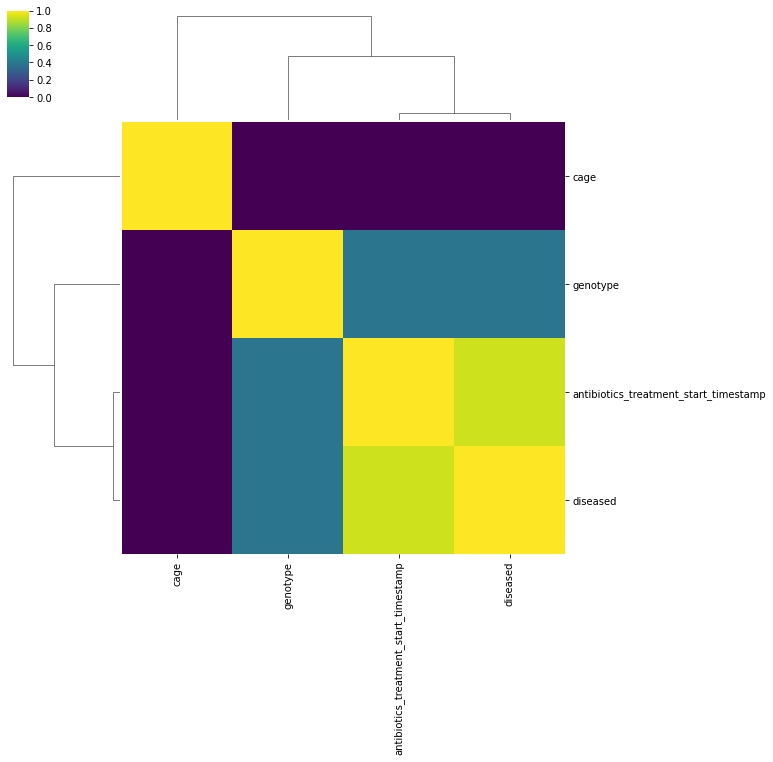

In [17]:
fields_categorials = ["genotype", "antibiotics_treatment_start_timestamp", "diseased", "cage"]
fields_intervals = []
fields_ordinals = {}
res_corr_meta = correlate_metadata(meta.loc[:, cols_toCheck], fields_categorials, fields_ordinals, fields_intervals)
#res_corr_meta[0]

Using existing results from '.anacache/f5bb16b03fc0790d771341b8833ff827.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/7c14a37b8c533df52eaa9f83784323a2.fRDAbeta'. 
Using existing results from '.anacache/dc5ae651a5a4873af8b8cae2f5382439.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/3a1c87045786c555b92d658bc4ff0de5.fRDAbeta'. 
No significant findings.
Using existing results from '.anacache/c5053f5eebe4648a1f2cde032f74f627.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/c744547ec91fd501f635a683c1934c29.fRDAbeta'. 
No significant findings.
Using existing results from '.anacache/e69d6b3e0ab394d337628b8de53003e8.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/2f8b6e3297ca8b6ba326b379171264a7.fRDAbeta'. 
Using existing results from '.anacache/0b8e02b732813bbe464ac48ecba4d0ed.fRDAalpha'. 
No significant findings.
Using existing results from '.anacache/fd65cbd847a1a7b09223bd9fa

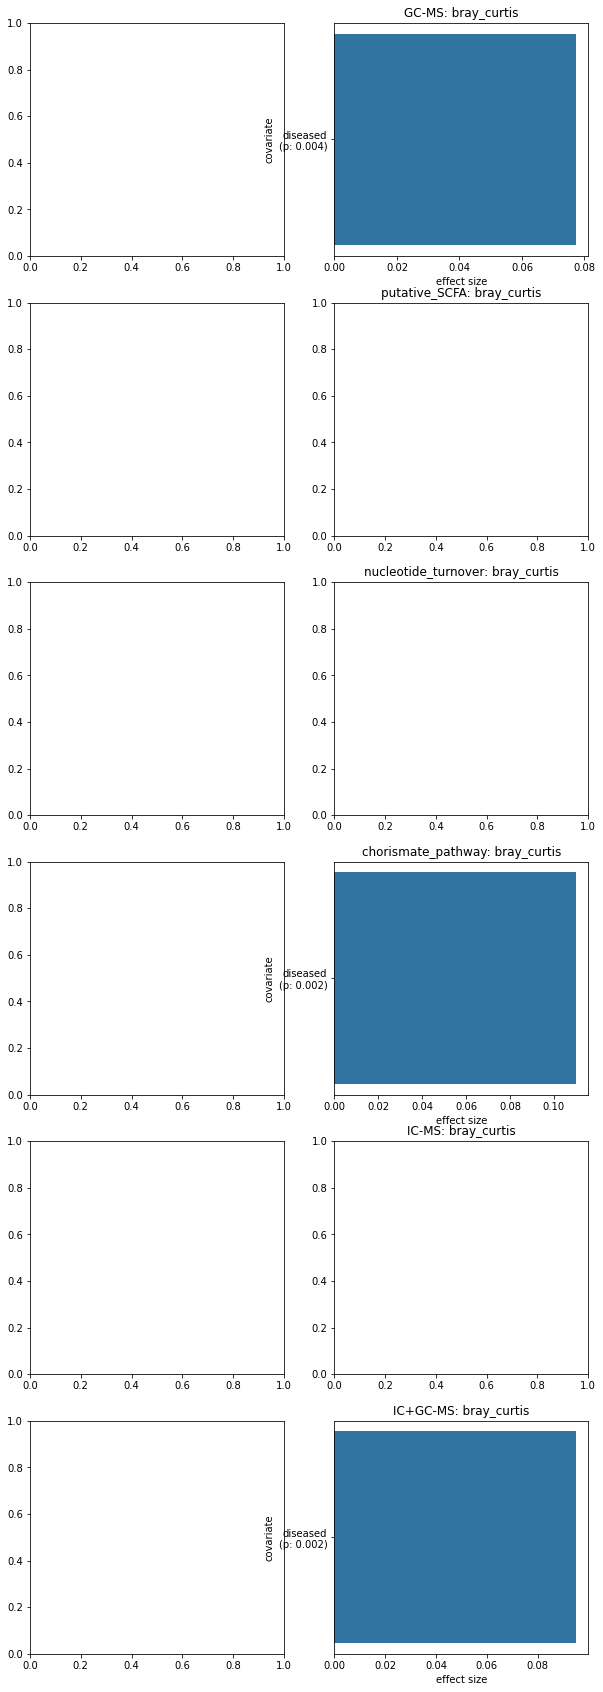

In [18]:
fields = ["diseased", "genotype"]
#fields = [c for c,r in (sig_cols.sum(axis=1) == sig_cols.shape[1]).iteritems() if r]

fig, axes = plt.subplots(len(counts.keys()), 2, figsize=(5*2, 5*len(counts.keys())))
for i, method in enumerate(counts.keys()):
    metric = 'shannon'
    _ = redundancy_analysis_alpha(meta, res_alpha[method]['results'][metric],
                                  categorials=fields, 
                                  ax=axes[i][0], title=metric,
                                  dry=False, wait=False)
    
    metric = 'bray_curtis'
    _ = redundancy_analysis_beta(meta, res_beta[method]['results'][metric], metric,
                                 categorials=fields, 
                                 ax=axes[i][1], title=metric,
                                 dry=False, wait=False)
    axes[i][1].set_title('%s: %s' % (method, metric))
#fig

## Specific analyses

In [19]:
e = dict()

fp_meta = 'Workdir/metabolome_diffabund_meta.tsv'
meta.to_csv(fp_meta, sep="\t", index=True)
for method in res_beta.keys():
    fp_diffabund = 'Workdir/metabolome_diffabund_%s.biom' % method
    pandas2biom(fp_diffabund, counts[method])
    e[method] = ca.read_amplicon(fp_diffabund, fp_meta, min_reads=0, normalize=10000)

### Non-diseased animals: difference WT vs. Pax5+/-

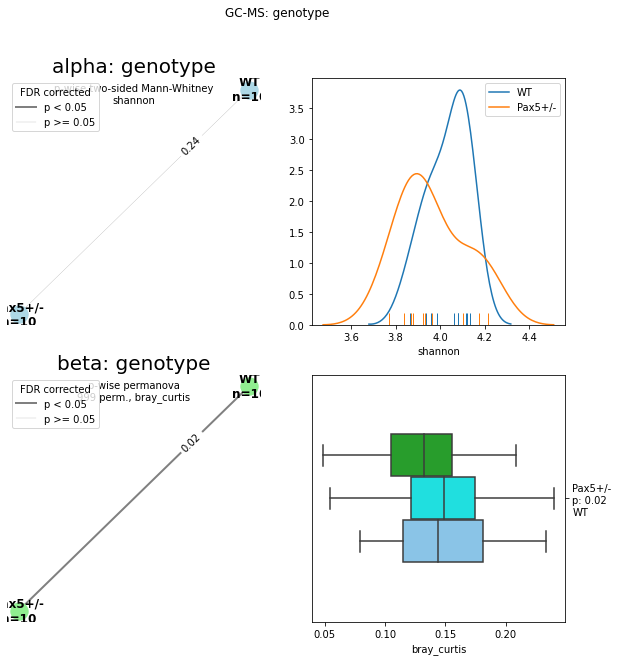

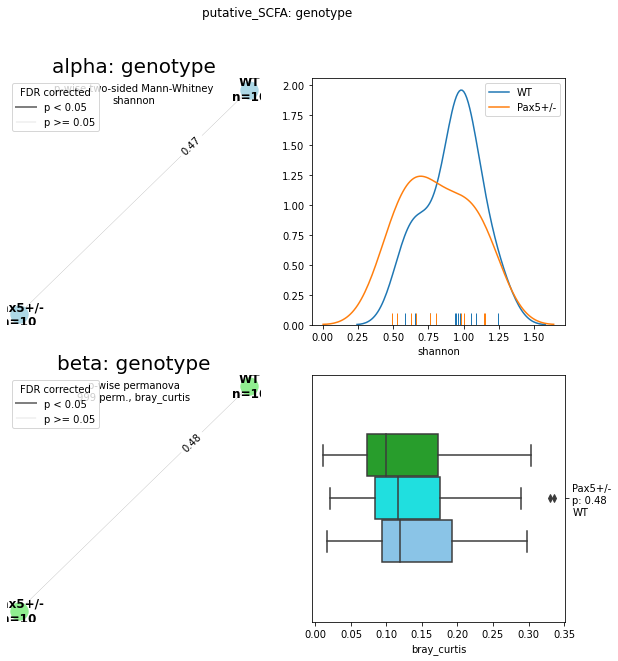

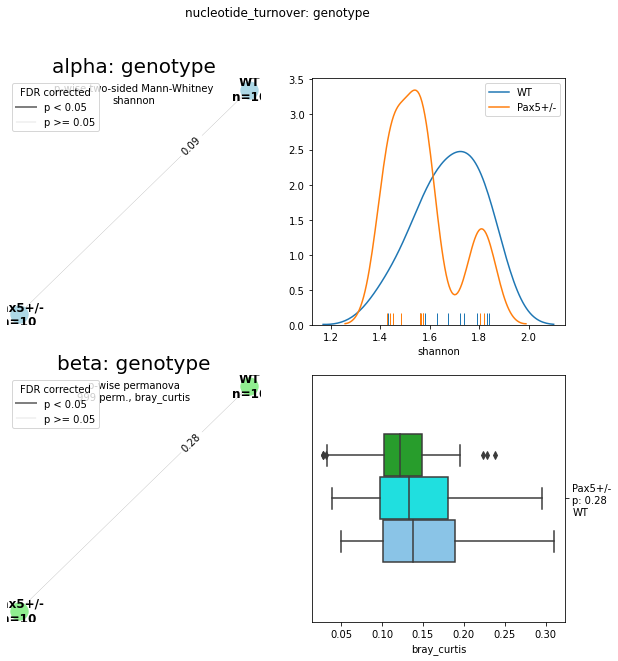

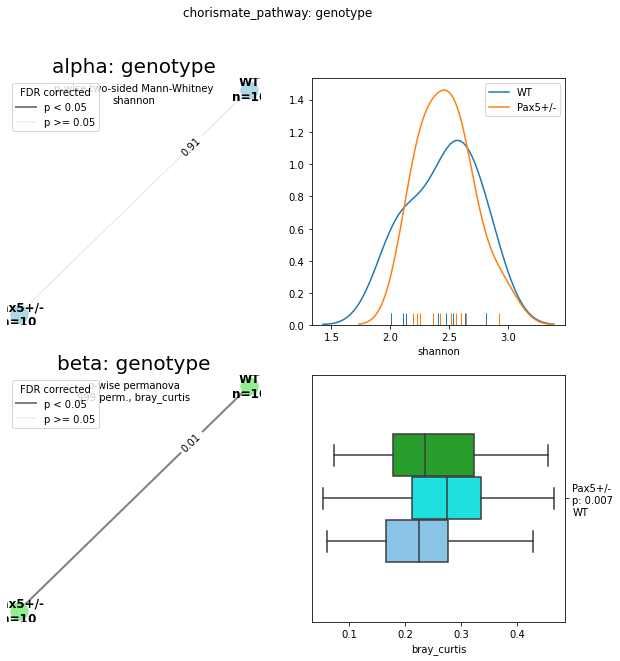

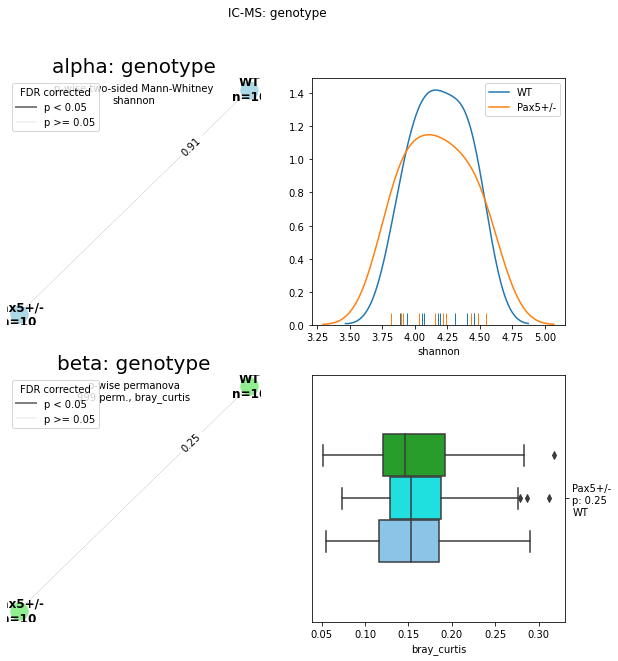

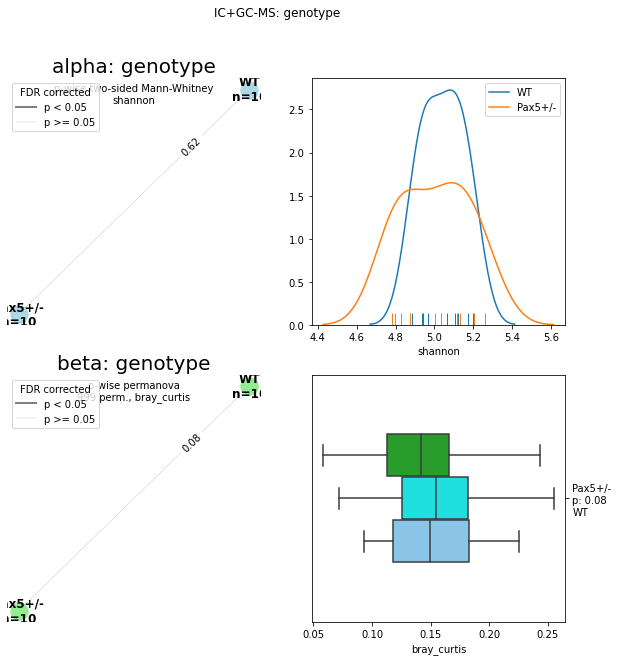

In [20]:
for method in res_beta.keys():
    p = plotNetworks("genotype", meta[meta['diseased'] == 'no'], res_alpha[method]['results'], {k: v for k,v in res_beta[method]['results'].items() if k == 'bray_curtis'}, minnumalpha=5, name='%s: genotype' % method)

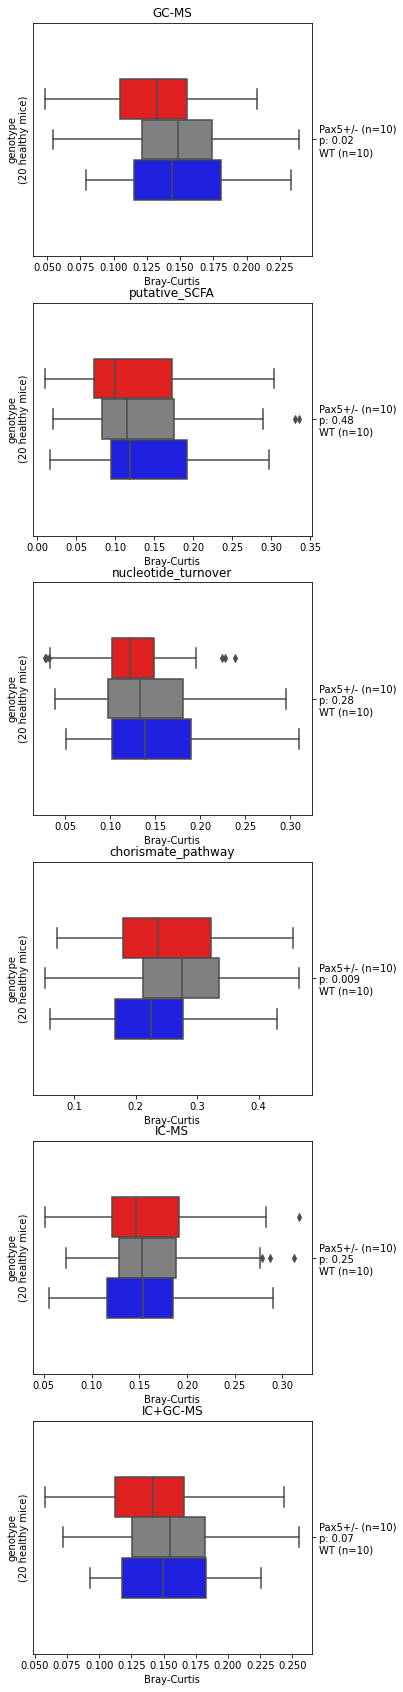

In [21]:
fig, axes = plt.subplots(len(counts.keys()),1, figsize=(1*5, len(counts.keys())*5))
for i, method in enumerate(res_beta.keys()):
    field = 'genotype'
    field_meta = meta[meta['diseased'] == 'no'][field]
    b = detect_distant_groups(res_beta[method]['results']['bray_curtis'], 'Bray-Curtis', field_meta)
    ax, _ = plotGroup_permanovas(res_beta[method]['results']['bray_curtis'], field_meta, **b,
                                 horizontal=True, print_sample_numbers=True, colors_boxplot={'between': 'gray', 'left': 'red', 'right': 'blue'}, ax=axes[i])
    ax.set_ylabel(field+ "\n(%i healthy mice)" % field_meta.shape[0])
    ax.yaxis.label.set_visible(True)
    ax.set_title(method)
_savefig(fig, 'metabolome_beta_genotype')

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=30)
     5 (of   56) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=37)
     0 (of   14) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)

'genotype'  (n=37)
     6 (of   12) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=37)
     5 (of    9) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=37)
   111 (of  402) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'genotype'  (n=30)
   105 (of  458) taxa different between 'WT' (n=10) vs. 'Pax5+/-' (n=10)



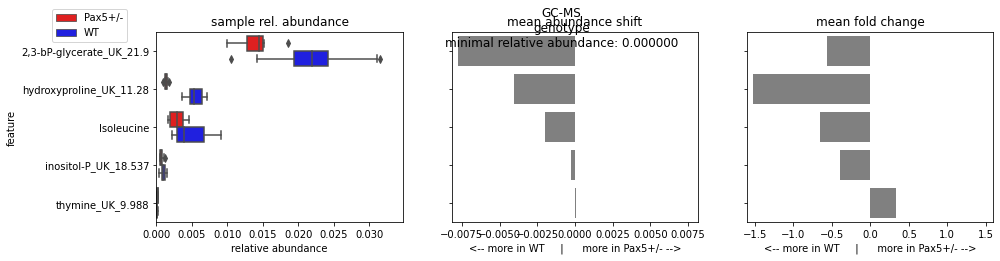

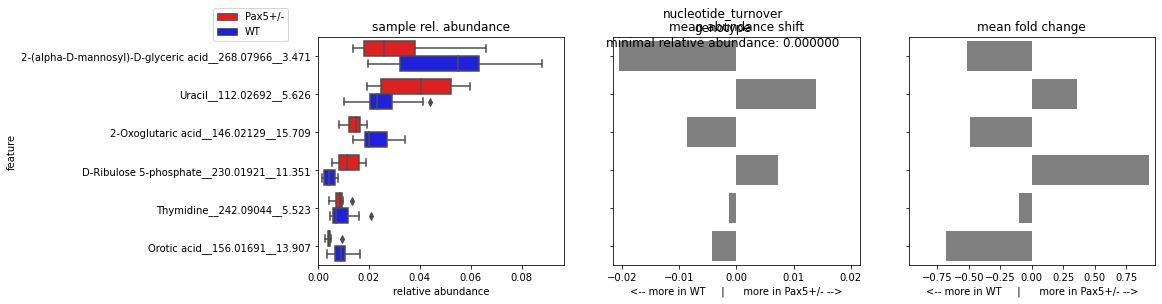

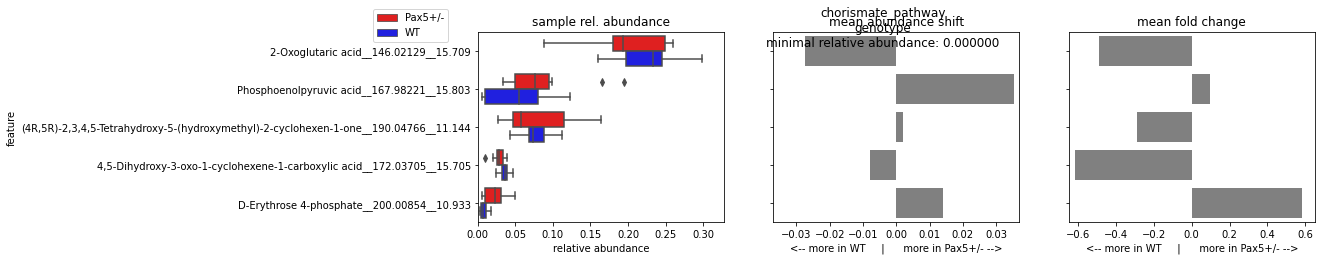

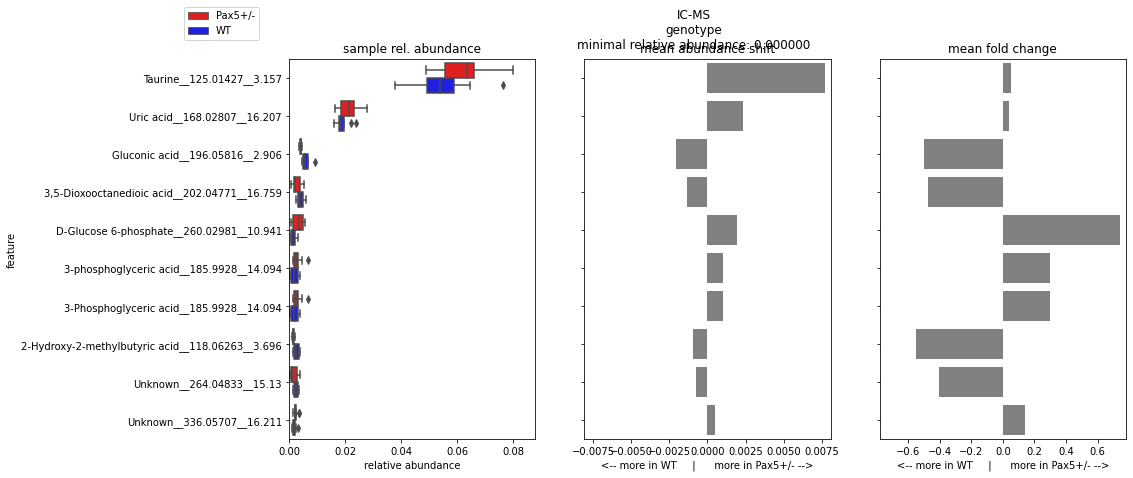

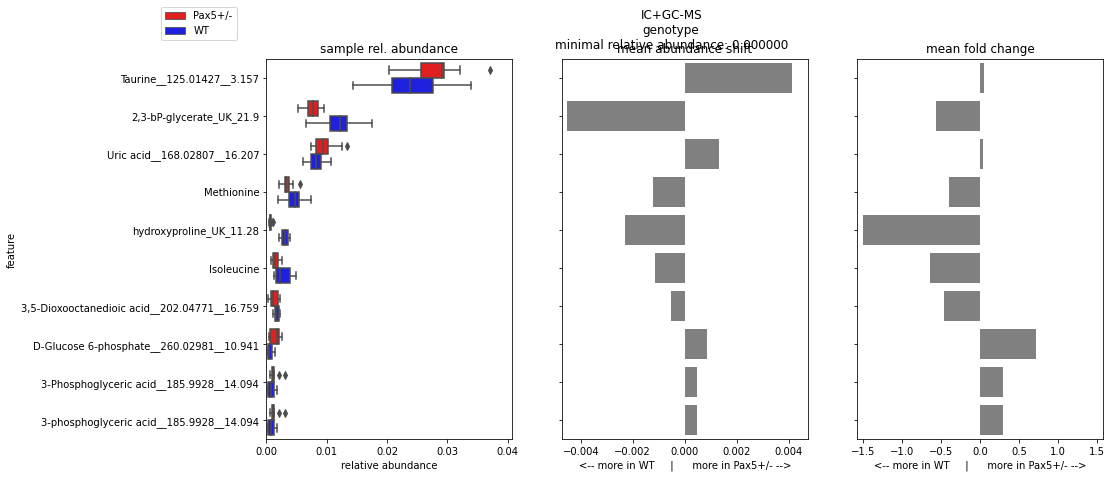

In [22]:
found_compounds = []

for method in res_beta.keys():
    field = 'genotype'
    res_dsFDR_genotype = find_diff_taxa(e[method], meta[meta['diseased'] == 'no'], [field])
    if len(res_dsFDR_genotype) > 0:
        p = plot_diff_taxa(counts[method], meta[meta['diseased'] == 'no'][field], res_dsFDR_genotype,
                           min_mean_abundance=0.0, title=method, topXfeatures=10,
                           colors_boxplot={'Pax5+/-': 'red', 'WT': 'blue'}, color_barplot='gray')
        _savefig(p[0], 'metabolome_dsfdr_genotype_%s' % method)
        found_compounds.extend([{'compound': x.get_text(), 'method': method, 'group': field, 'found': 1} for x in p[0].axes[0].get_yticklabels()])

### Pax5+/- animals: sick vs. healthy

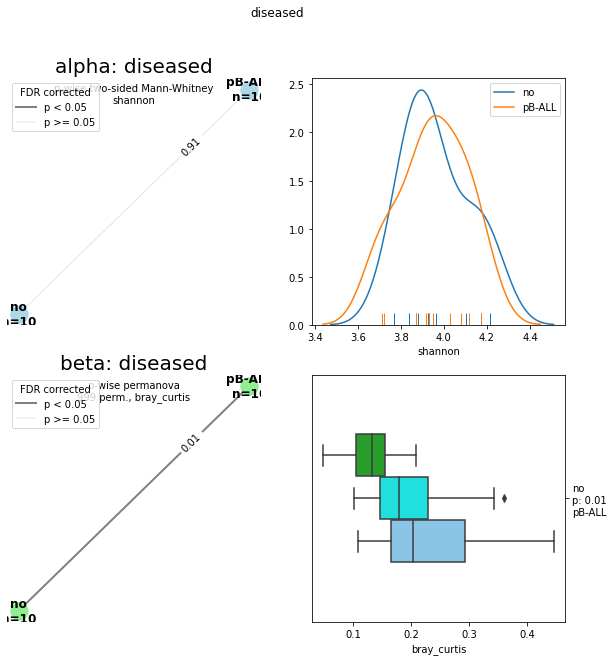

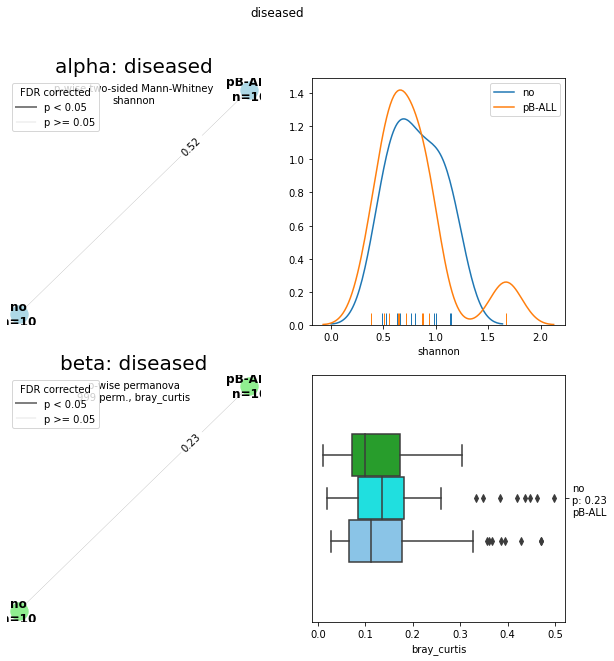

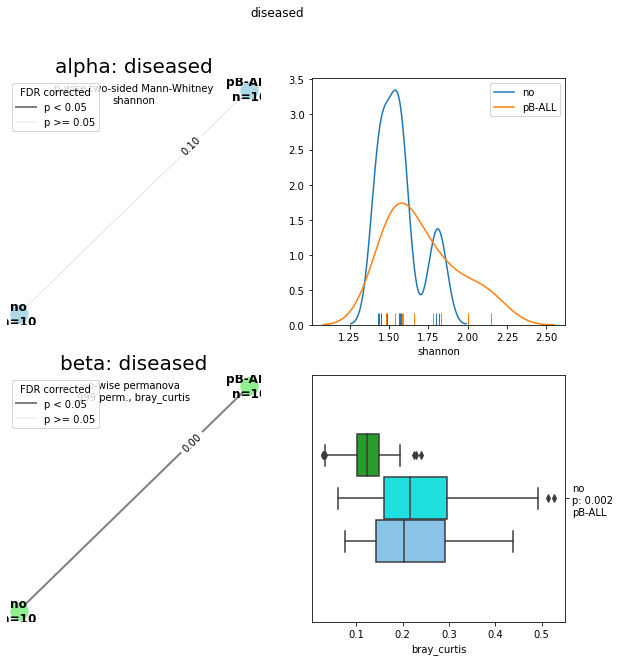

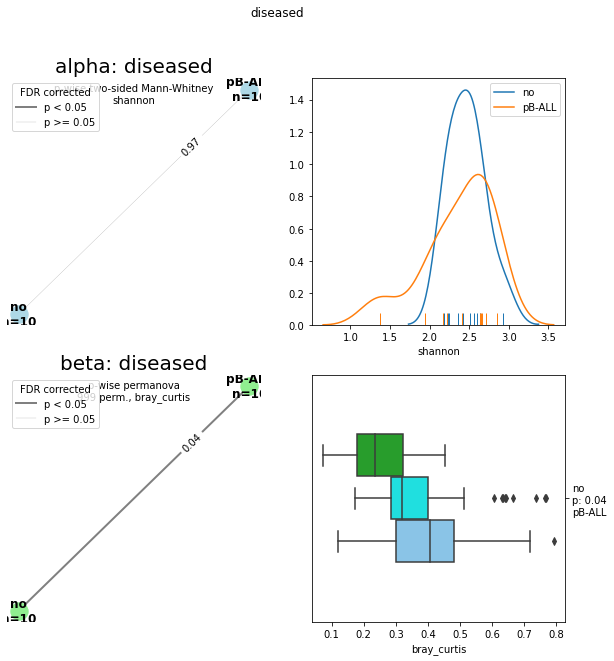

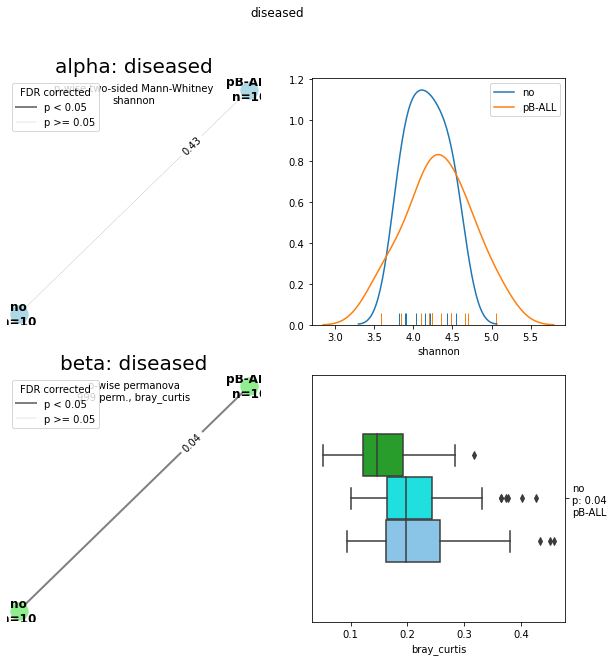

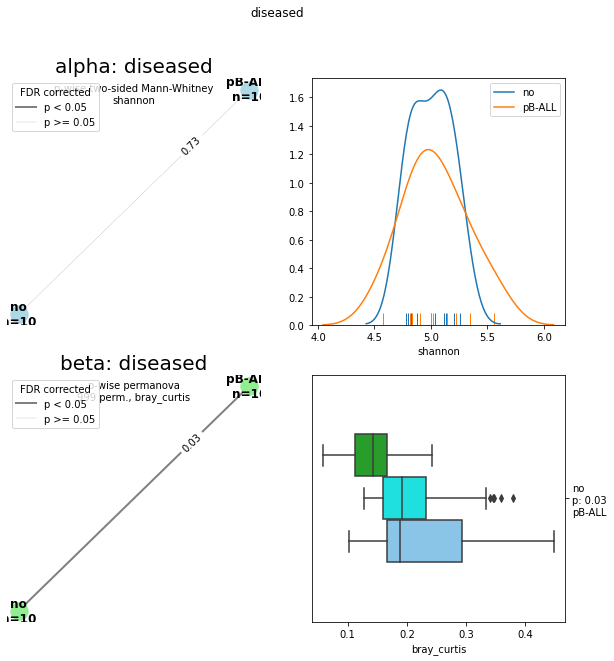

In [23]:
for method in res_beta.keys():
    p = plotNetworks("diseased", meta[meta['genotype'] == 'Pax5+/-'], res_alpha[method]['results'], {k: v for k,v in res_beta[method]['results'].items() if k == 'bray_curtis'}, minnumalpha=5, name='diseased')
    #_savefig(p, 'network_diseased')

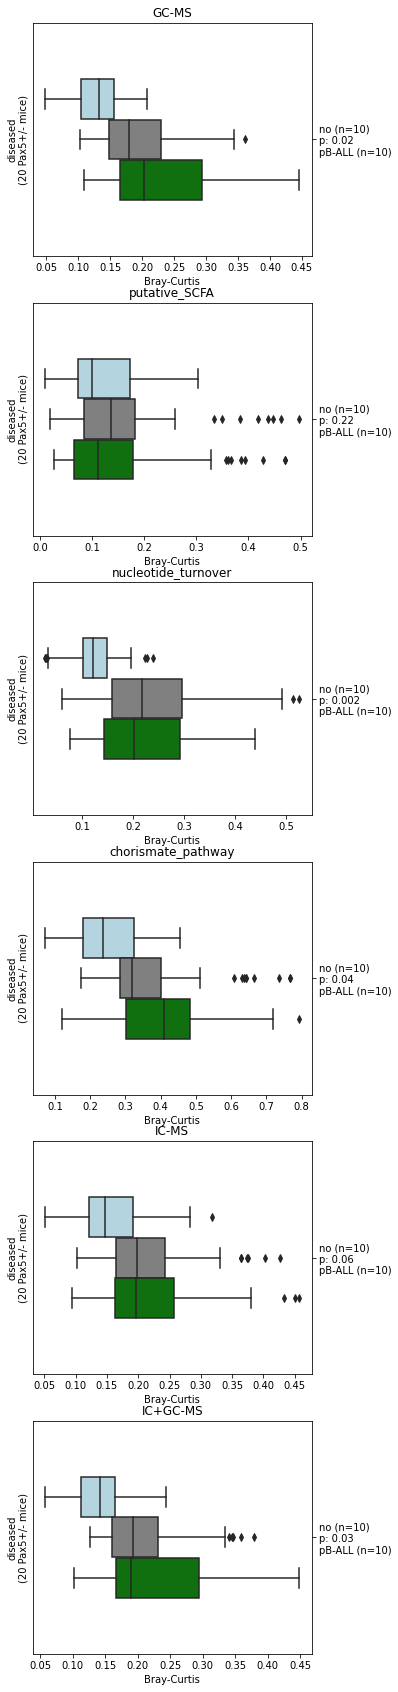

In [24]:
fig, axes = plt.subplots(len(counts.keys()),1, figsize=(1*5, len(counts.keys())*5))
for i, method in enumerate(res_beta.keys()):
    field = 'diseased'
    field_meta = meta[meta['genotype'] == 'Pax5+/-'][field]
    b = detect_distant_groups(res_beta[method]['results']['bray_curtis'], 'Bray-Curtis', field_meta)
    ax, _ = plotGroup_permanovas(res_beta[method]['results']['bray_curtis'], field_meta, **b,
                                 horizontal=True, print_sample_numbers=True, colors_boxplot={'between': 'gray', 'left': 'lightblue', 'right': 'green'}, ax=axes[i])
    ax.set_ylabel(field+ "\n(%i Pax5+/- mice)" % field_meta.shape[0])
    ax.yaxis.label.set_visible(True)
    ax.set_title(method)
_savefig(fig, 'metabolome_beta_disease')

/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=30)
    17 (of   56) taxa different between 'no' (n=10) vs. 'pB-ALL' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=37)
     2 (of   14) taxa different between 'no' (n=10) vs. 'pB-ALL' (n=10)

Warnings: no taxa left!


/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=37)
     6 (of   12) taxa different between 'no' (n=10) vs. 'pB-ALL' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=37)
     6 (of    9) taxa different between 'no' (n=10) vs. 'pB-ALL' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=37)
   178 (of  402) taxa different between 'no' (n=10) vs. 'pB-ALL' (n=10)



/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


'diseased'  (n=30)
   189 (of  458) taxa different between 'no' (n=10) vs. 'pB-ALL' (n=10)



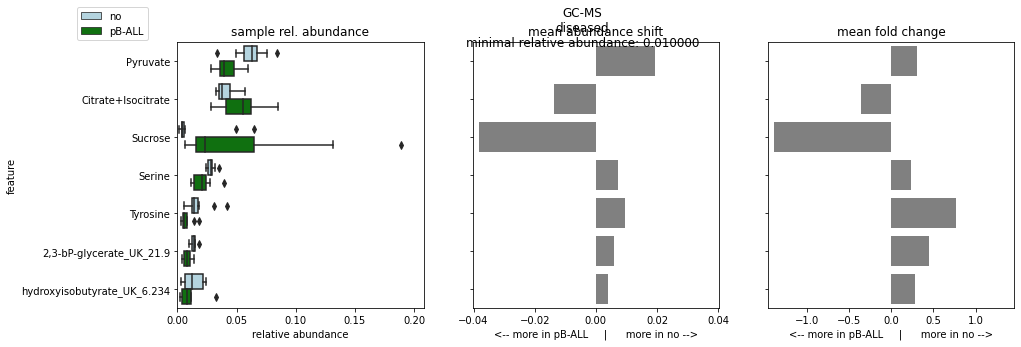

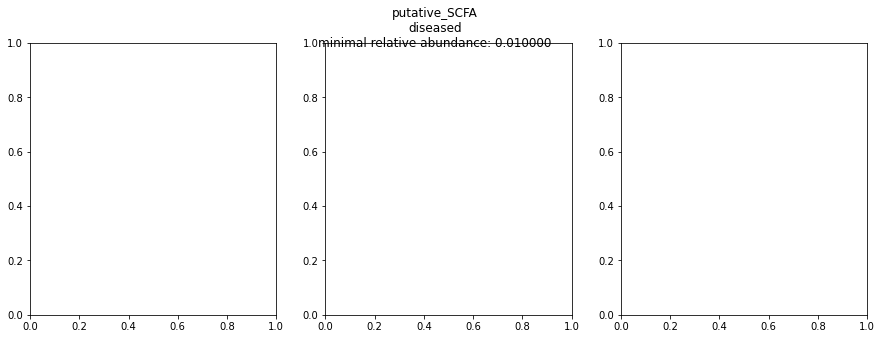

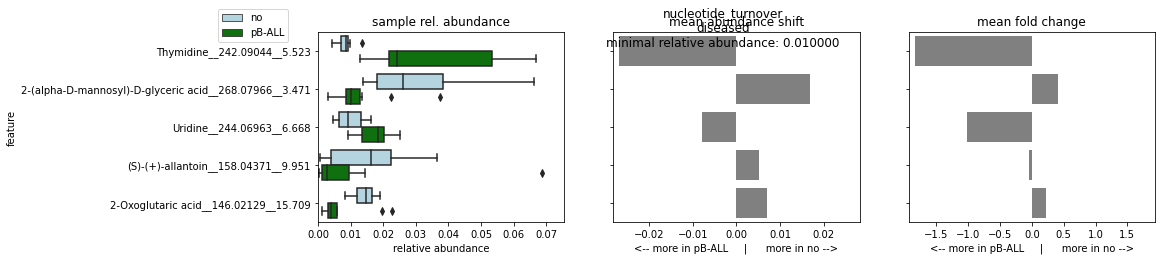

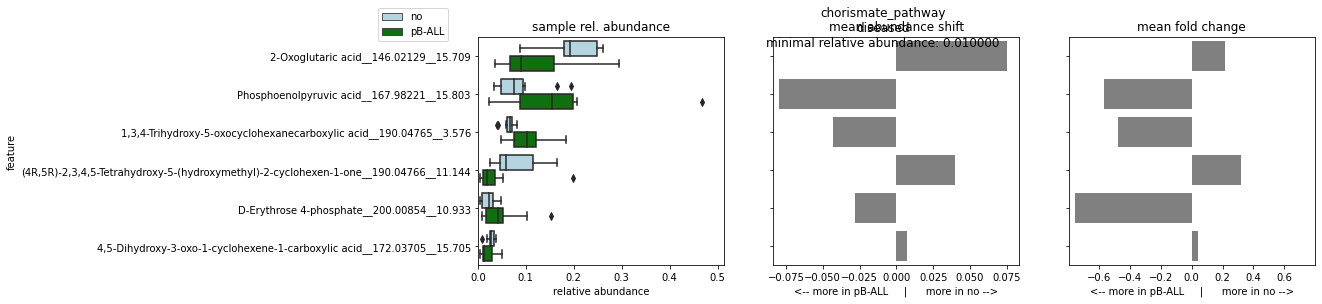

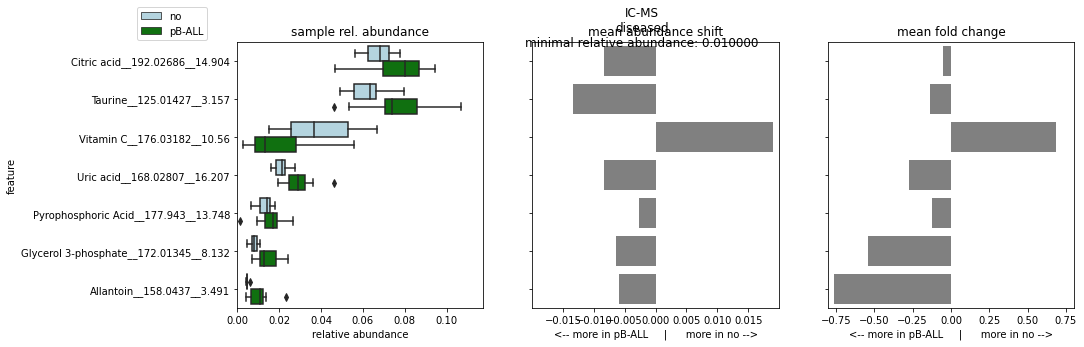

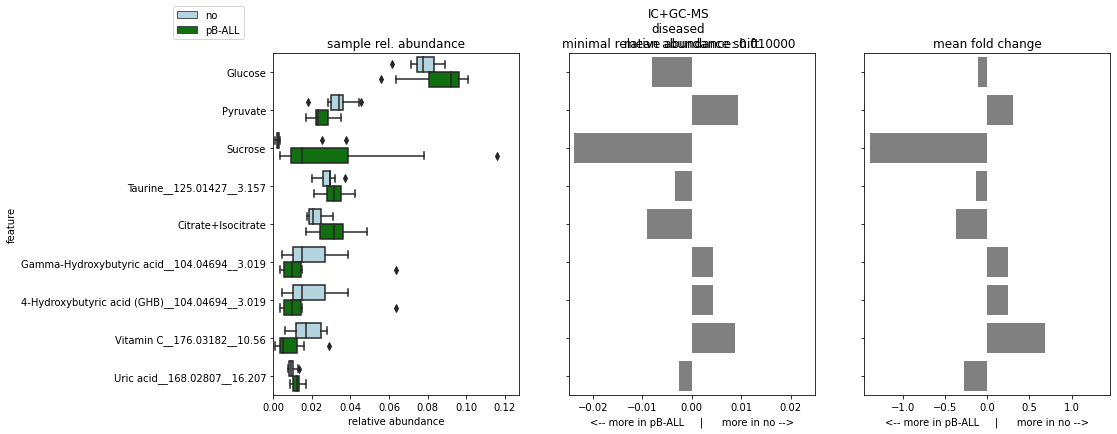

In [25]:
for method in res_beta.keys():
    field = 'diseased'
    res_dsFDR_diseased = find_diff_taxa(e[method], meta[meta['genotype'] == 'Pax5+/-'], [field])
    if len(res_dsFDR_diseased) > 0:
        p = plot_diff_taxa(counts[method], meta[meta['genotype'] == 'Pax5+/-'][field], res_dsFDR_diseased, min_mean_abundance=0.01,
                           title=method, topXfeatures=10,
                           colors_boxplot={'no': 'lightblue', 'pB-ALL': 'green'}, color_barplot='gray')
        _savefig(p[0], 'metabolome_dsfdr_disease_%s' % method)
        found_compounds.extend([{'compound': x.get_text(), 'method': method, 'group': field, 'found': 1} for x in p[0].axes[0].get_yticklabels()])

In [26]:
list_compounds = pd.pivot_table(data=pd.DataFrame(found_compounds), index=('group', 'method'), columns='compound', values='found').T
list_compounds = list_compounds.loc[list_compounds.sum(axis=1).sort_values(ascending=False).index,:].applymap(lambda x: '' if np.isnan(x) else 'X')
list_compounds.to_excel('found_compunds.xlsx')
list_compounds

group                                              diseased                 \
method                                                GC-MS IC+GC-MS IC-MS   
compound                                                                     
Uric acid__168.02807__16.207                                       X     X   
2-Oxoglutaric acid__146.02129__15.709                                        
Taurine__125.01427__3.157                                          X     X   
2,3-bP-glycerate_UK_21.9                                  X                  
(4R,5R)-2,3,4,5-Tetrahydroxy-5-(hydroxymethyl)-...                           
Phosphoenolpyruvic acid__167.98221__15.803                                   
4,5-Dihydroxy-3-oxo-1-cyclohexene-1-carboxylic ...                           
D-Erythrose 4-phosphate__200.00854__10.933                                   
D-Glucose 6-phosphate__260.02981__10.941                                     
3-phosphoglyceric acid__185.9928__14.094                                     
3-Phosphoglyceric acid__185.9928__14.094                                     
3,5-Dioxooctanedioic acid__202.04771__16.759                                 
Isoleucine                                                                   
2-(alpha-D-mannosyl)-D-glyceric acid__268.07966...                           
Pyruvate                                                  X        X         
Sucrose                                                   X        X         
Thymidine__242.09044__5.523                                                  
Vitamin C__176.03182__10.56                                        X     X   
hydroxyproline_UK_11.28                                                      
Citrate+Isocitrate                                        X        X         
4-Hydroxybutyric acid (GHB)__104.04694__3.019                      X         
1.0                                                                          
1,3,4-Trihydroxy-5-oxocyclohexanecarboxylic aci...                           
0.8                                                                          
2-Hydroxy-2-methylbutyric acid__118.06263__3.696                             
0.6                                                                          
0.4                                                                          
0.2                                                                          
0.0                                                                          
(S)-(+)-allantoin__158.04371__9.951                                          
thymine_UK_9.988                                                             
Allantoin__158.0437__3.491                                               X   
Citric acid__192.02686__14.904                                           X   
hydroxyisobutyrate_UK_6.234                               X                  
Uridine__244.06963__6.668                                                    
Uracil__112.02692__5.626                                                     
Unknown__336.05707__16.211                                                   
Unknown__264.04833__15.13                                                    
Tyrosine                                                  X                  
Serine                                                    X                  
Pyrophosphoric Acid__177.943__13.748                                     X   
Orotic acid__156.01691__13.907                                               
Methionine                                                                   
Glycerol 3-phosphate__172.01345__8.132                                   X   
Glucose                                                            X         
Gluconic acid__196.05816__2.906                                              
inositol-P_UK_18.537                                                         
D-Ribulose 5-phosphate__230.01921__11.351                                    
Gamma-Hydroxybutyric a

### In Order to limit diff abundant compounds: compare all 20 Pax5 vs. 10 WT (ignoring ABX treatment)

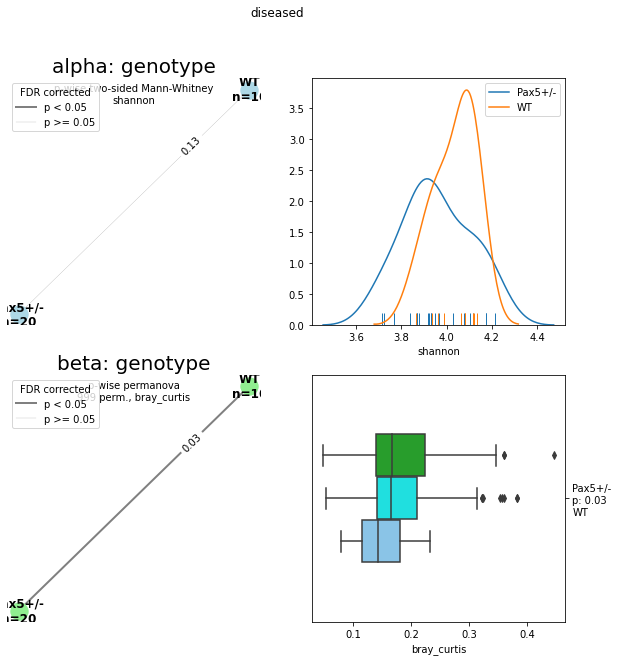

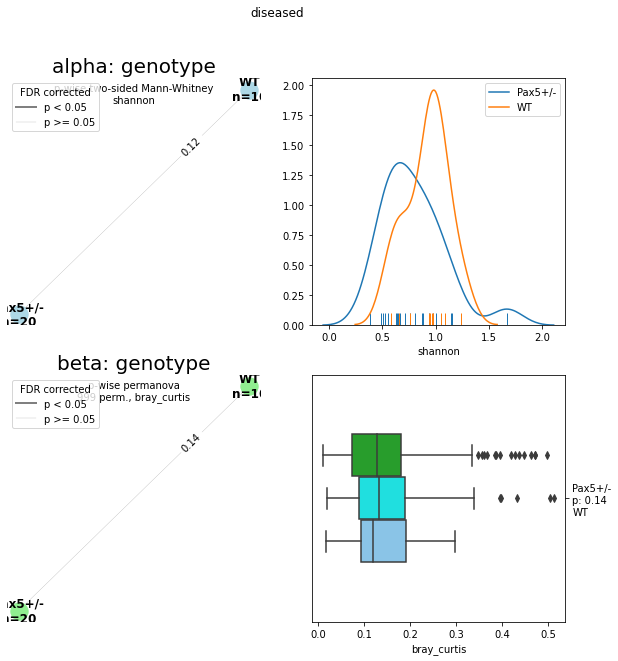

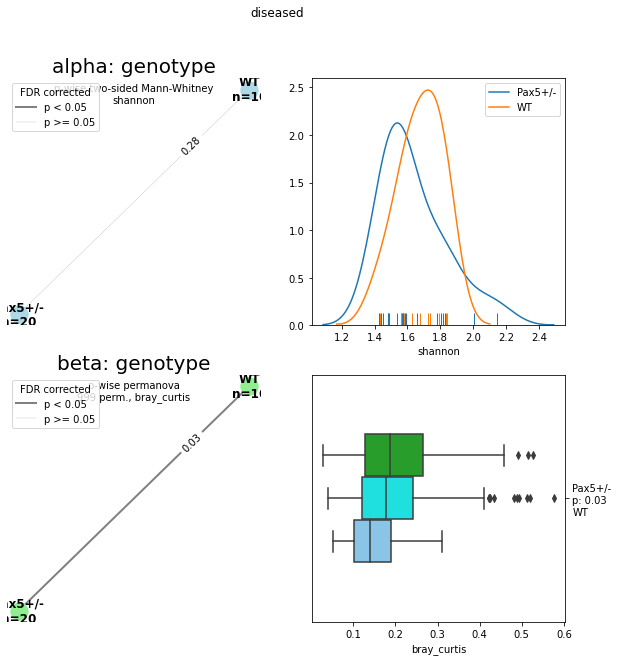

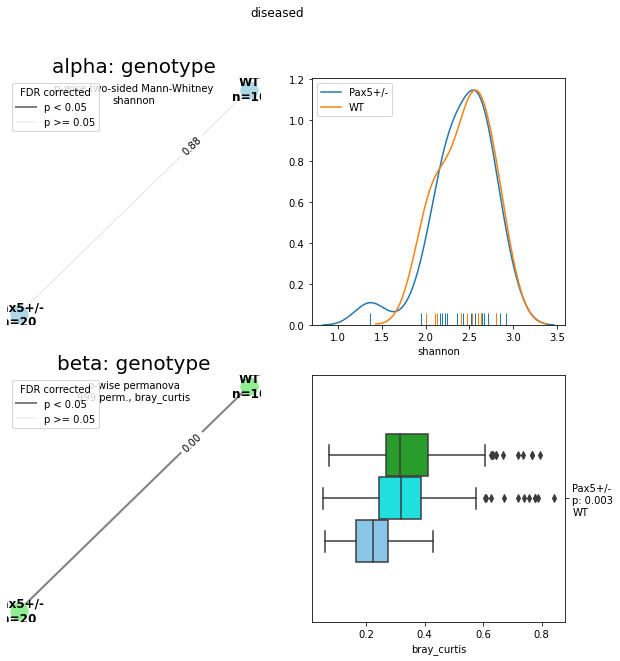

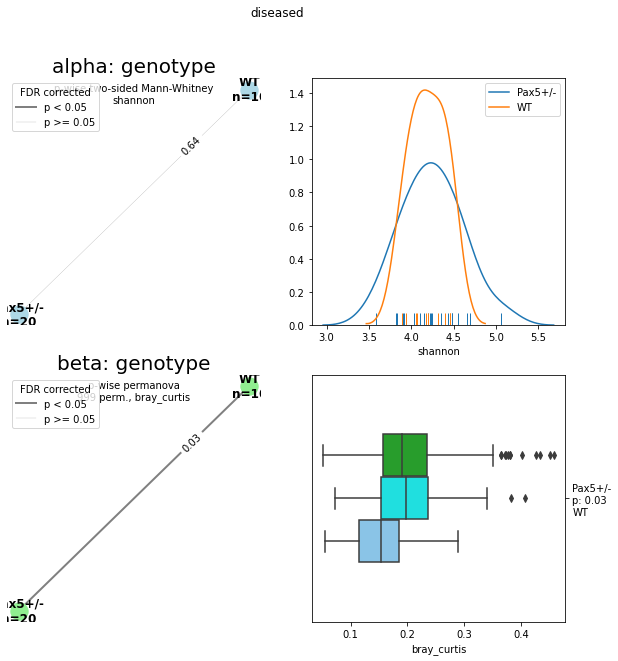

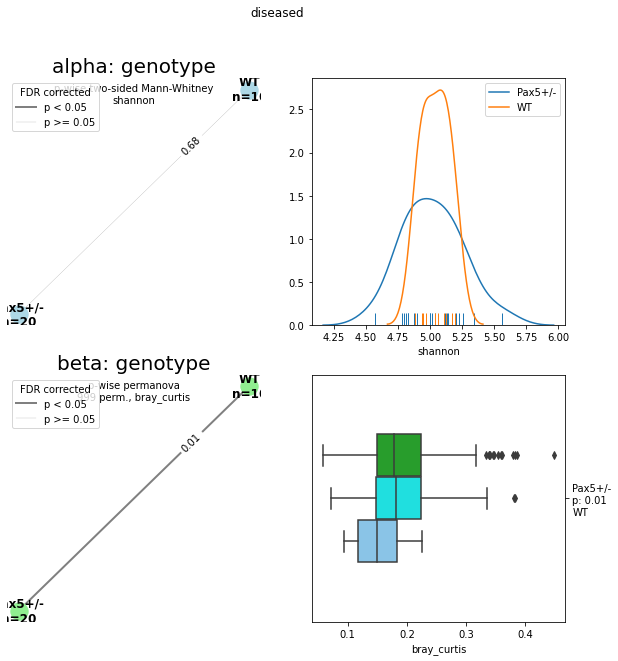

In [31]:
for method in res_beta.keys():
    p = plotNetworks("genotype", meta, res_alpha[method]['results'], {k: v for k,v in res_beta[method]['results'].items() if k == 'bray_curtis'}, minnumalpha=5, name='diseased')
    #_savefig(p, 'network_diseased')

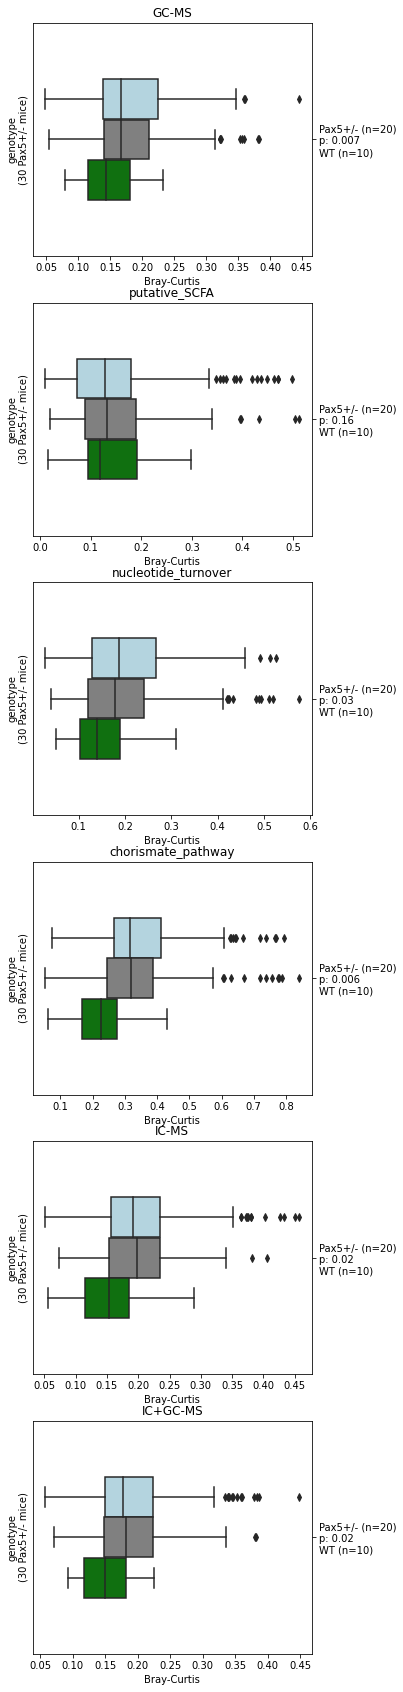

In [32]:
fig, axes = plt.subplots(len(counts.keys()),1, figsize=(1*5, len(counts.keys())*5))
for i, method in enumerate(res_beta.keys()):
    field = 'genotype'
    field_meta = meta[field]
    b = detect_distant_groups(res_beta[method]['results']['bray_curtis'], 'Bray-Curtis', field_meta)
    ax, _ = plotGroup_permanovas(res_beta[method]['results']['bray_curtis'], field_meta, **b,
                                 horizontal=True, print_sample_numbers=True, colors_boxplot={'between': 'gray', 'left': 'lightblue', 'right': 'green'}, ax=axes[i])
    ax.set_ylabel(field+ "\n(%i Pax5+/- mice)" % field_meta.shape[0])
    ax.yaxis.label.set_visible(True)
    ax.set_title(method)
_savefig(fig, 'metabolome_beta_disease')

method: GC-MS
'genotype'  (n=30)
     6 (of   56) taxa different between 'Pax5+/-' (n=20) vs. 'WT' (n=10)

method: IC-MS
'genotype'  (n=37)


/homes/sjanssen/miniconda3/envs/notebookServer/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


   113 (of  402) taxa different between 'Pax5+/-' (n=20) vs. 'WT' (n=10)

method: IC+GC-MS
'genotype'  (n=30)
   114 (of  458) taxa different between 'Pax5+/-' (n=20) vs. 'WT' (n=10)



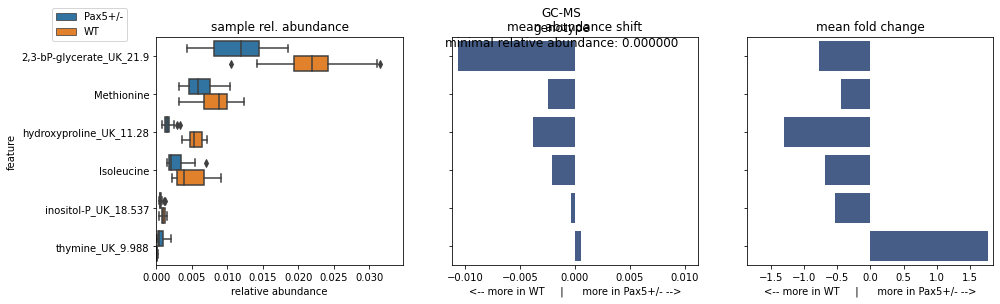

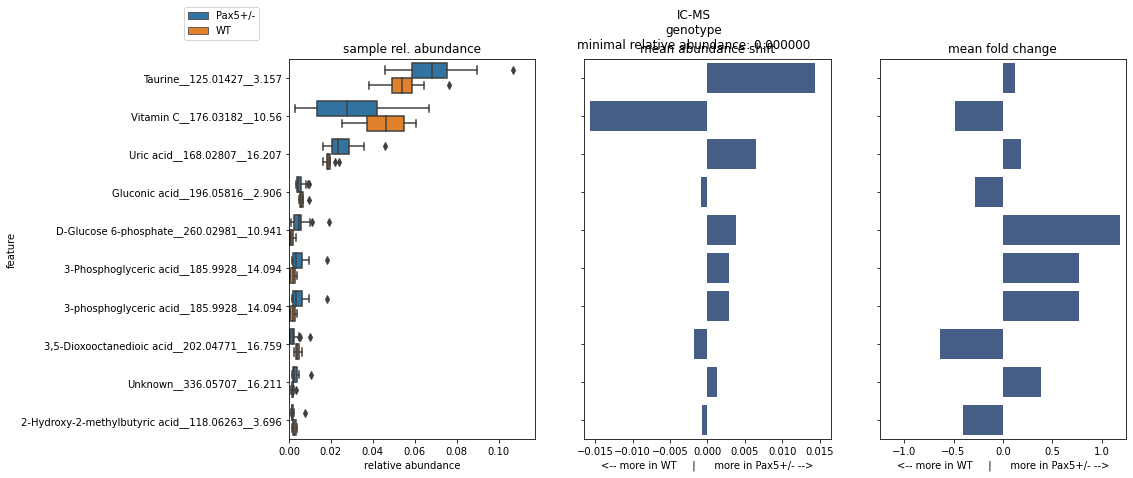

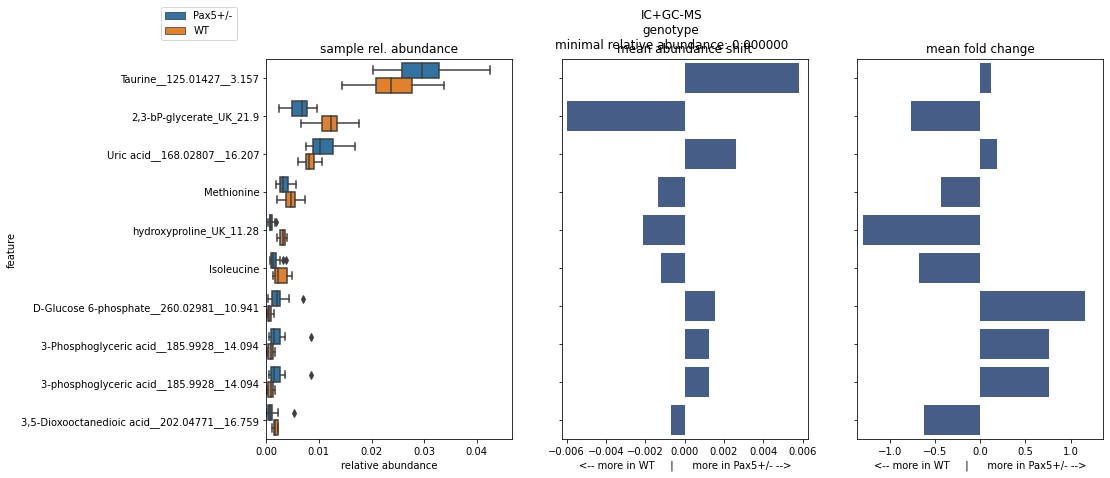

In [42]:
for method in res_beta.keys():
    if '-' not in method:
        continue
    print("method: %s" % method)
    field = 'genotype'
    res_dsFDR_diseased = find_diff_taxa(e[method], meta, [field])
    if 0 < len(res_dsFDR_diseased) <= 20:
        p = plot_diff_taxa(counts[method], meta[field], res_dsFDR_diseased, min_mean_abundance=0,
                           title=method, topXfeatures=10,
                           )
        _savefig(p[0], 'metabolome_dsfdr_disease_%s' % method)
        found_compounds.extend([{'compound': x.get_text(), 'method': method, 'group': field, 'found': 1} for x in p[0].axes[0].get_yticklabels()])

## Volcano Plot

In [45]:
field = 'genotype'
#field = 'diseased'

samples = meta[meta['diseased'] == 'no'][field]
#samples = meta[meta['genotype'] == 'Pax5+/-'][field]
if samples.value_counts().shape[0] != 2:
    raise ValueError("selected metadata field has more or less than two states!")
    
res = []
for feature, g in counts['IC+GC-MS'].stack().reset_index().merge(samples.to_frame(), left_on='sample_name', right_index=True, how='right').groupby('feature'):
    #print(feature)
    grps = g.groupby(field)
    vals_grp_a = list(grps)[0][1][0].values
    vals_grp_b = list(grps)[1][1][0].values
    ttest = ttest_ind(vals_grp_a, vals_grp_b)
    res.append({'statistic': ttest.statistic, 
                'pvalue': ttest.pvalue, 
                'fold-change': np.mean(np.log2(vals_grp_a / vals_grp_b)),
                'cmp': (list(grps)[0][0], list(grps)[1][0]),
                'Compound': feature})
res = pd.DataFrame(res).set_index('Compound')
res['pvalue'] = res['pvalue'].apply(np.log10)*-1
res.loc[counts['IC+GC-MS'].index,'group'] = 'background'
for k in counts.keys():
    if not k.endswith('-MS'):
        res.loc[counts[k].index,'group'] = k

Text(0.5, 0, 'fold-change\nPax5+/- vs. WT')

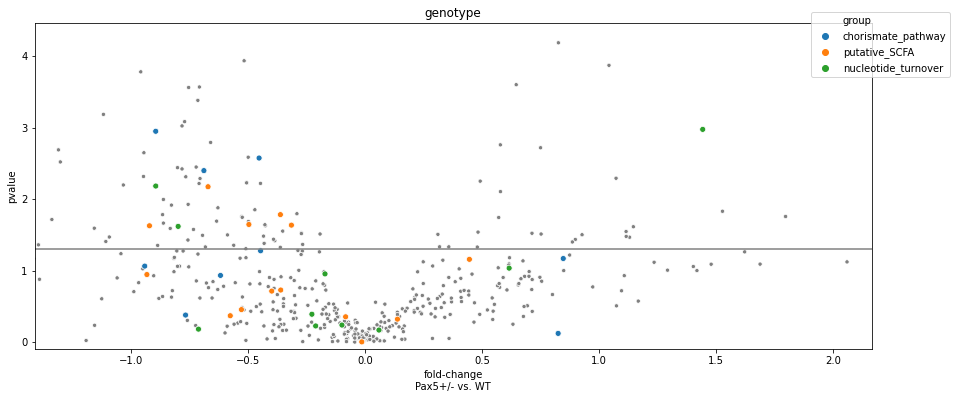

In [46]:
fig, axes = plt.subplots(1,1,figsize=(15,6))
g = sns.scatterplot(data=res[res['group'] == 'background'], x='fold-change', y='pvalue', color='gray', size=1, legend=None, ax=axes)
g.hlines(-1*np.log10(0.05),xmin=-5,xmax=5, color='gray')
g = sns.scatterplot(data=res[res['group'] != 'background'], x='fold-change', y='pvalue', hue='group', ax=axes, sizes=3)
g.set_xlim(res[res['group'] != 'background']['fold-change'].min()*1.5, res[res['group'] != 'background']['fold-change'].max()*1.5)
g.set_ylim(-0.1, res[res['group'] != 'background']['pvalue'].max()*1.5)
g.legend(bbox_to_anchor=(1.1, 1.05))
g.set_title(field)

g.set_xlabel(g.get_xlabel()+"\n" + ' vs. '.join(res['cmp'].unique()[0]))

## Speculation about Chorismate Pathway

kegg
C00026   -0.709626
C00064   -0.415474
C00074    0.141000
C00279    0.838445
C00493   -0.403247
C00944   -0.442057
C02637   -1.061295
dtype: float64

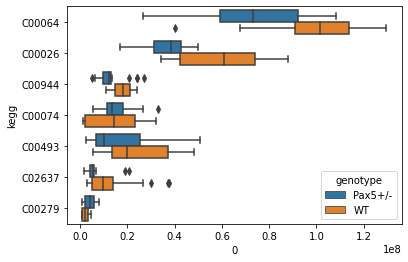

In [29]:
data = counts['chorismate_pathway'].stack().reset_index().merge(meta[meta['diseased'] == 'no']['genotype'], left_on="sample_name", right_index=True)
data['kegg'] = data['feature'].apply(lambda x: keggmap[x])
#display(data.head())
sns.boxplot(data=data, x=0, y='kegg', hue='genotype')

fc = data.groupby(['kegg', 'genotype'])[0].mean().unstack().reset_index().set_index('kegg')
fc = fc.apply(lambda x: np.log2(x['Pax5+/-'] / x['WT']), axis=1)
fc
#fc.reset_index()
#fc

#data = p[2].loc[['2-Oxoglutaric acid__146.02129__15.709'], :].T.merge(meta[meta['diseased'] == 'no']['genotype'], left_index=True, right_index=True)
#sns.boxplot(data=data, y='2-Oxoglutaric acid__146.02129__15.709', x='genotype', color='white')
#sns.swarmplot(data=data, y='2-Oxoglutaric acid__146.02129__15.709', x='genotype')

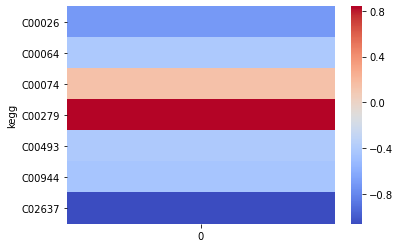

In [30]:
sns.heatmap(fc.to_frame(), cmap='coolwarm')